In [6]:
import os
import requests
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
from multiprocessing import Pool
import subprocess

In [7]:
def getCMD(param_path):
    CLASSPATH="/Users/jiaqiangruan/CMU/SearchEngine/out/production/SearchEngine:"+ \
              "/Users/jiaqiangruan/CMU/SearchEngine/lucene-8.1.1/lucene-core-8.1.1.jar:"+ \
              "/Users/jiaqiangruan/CMU/SearchEngine/lucene-8.1.1/QryEvalExtensions.jar:"+ \
              "/Users/jiaqiangruan/CMU/SearchEngine/lucene-8.1.1/lucene-codecs-8.1.1.jar:"+ \
              "/Users/jiaqiangruan/CMU/SearchEngine/lucene-8.1.1/lucene-analyzers-common-8.1.1.jar"
    cmd = "java -classpath %s QryEval %s" % (CLASSPATH, param_path)
    return cmd

In [8]:
def test(output_path):
    userId = 'jruan@andrew.cmu.edu'
    password = 'YOz4vZdm'
    hwId = 'HW2'
    qrels = 'topics.701-850.qrel'

    #  Form parameters - these must match form parameters in the web page

    url = 'https://boston.lti.cs.cmu.edu/classes/11-642/HW/HTS/tes.cgi'
    values = { 'hwid' : hwId,				# cgi parameter
               'qrel' : qrels,				# cgi parameter
               'logtype' : 'Summary',			# cgi parameter
               'leaderboard' : 'No'				# cgi parameter
               }

    #  Make the request

    files = {'infile' : (output_path, open(output_path, 'rb')) }	# cgi parameter
    result = requests.post (url, data=values, files=files, auth=(userId, password))

    #  Replace the <br /> with \n for clarity

    # print (result.text.replace ('<br />', '\n'))
    # data = result.text.split('<br />')
    # for line in data:
    #     if "P_10" in line:
    #         print(line)
    data = result.text
    data = data[data.index('<pre>'):data.index('</pre>')]
    data = data.split('\n')
    ans = {}
    for line in data:
        if 'P_10 ' in line:
            ans['P@10'] = float(line.split()[2])
        if 'P_20 ' in line:
            ans['P@20'] = float(line.split()[2])
        if 'P_30 ' in line:
            ans['P@30'] = float(line.split()[2])
        if 'map ' in line:
            ans['MAP'] = float(line.split()[2])
    return ans

# EXP 5

In [9]:
param_text = """indexPath=INPUT_DIR/index-gov2
queryFilePath=TEST_DIR/HW2-Exp-%s.qry
trecEvalOutputPath=OUTPUT_DIR/HW2-Exp-%s.teIn
trecEvalOutputLength=100
retrievalAlgorithm=Indri
Indri:mu=1500
Indri:lambda=0.01"""

indexes = []
for a in np.arange(0,1.1,0.1):
    for b in np.arange(0,1.1,0.1):
#         c = 1.0-a-b
#         if c>=0.0 and c<=1.0:
        for c in np.arange(0,1.1,0.1):

            out = subprocess.Popen(["perl","DonMetzler.pl",str(a),str(b),str(c)], 
                       stdout=subprocess.PIPE, 
                       stderr=subprocess.STDOUT)
            stdout,stderr = out.communicate()
            qry_text = stdout.decode('utf-8')
            
            index = "7-%f-%f-%f" %(a,b,c)
            indexes.append(index)
            with open("PARAM_DIR/HW2-Exp-%s.param"%index, 'w+') as f:
                f.write(param_text%(index, index))
            with open("TEST_DIR/HW2-Exp-%s.qry"%index, 'w+') as f:
                f.write(qry_text)

In [10]:
def run(index):
    params_path = "PARAM_DIR/HW2-Exp-%s.param" % index
    os.system(getCMD(params_path))

def run_test(index):
    output_path = 'OUTPUT_DIR/HW2-Exp-%s.teIn' % index
    tmp = test(output_path)
    return tmp

In [11]:
with Pool(8) as p:
    list(tqdm(p.imap_unordered(run, indexes)))

summary = {}
for index in tqdm(indexes):
    summary[index] = run_test(index)

with open('exp5-4.pkl', 'wb') as f:
    pkl.dump(summary, f) 

1331it [3:49:46, 10.36s/it]
100%|██████████| 1331/1331 [22:10<00:00,  1.00it/s]


In [3]:
summary = {}
with open('exp5-4.pkl', 'rb') as f:
    summary.update(pkl.load(f))

Text(0.5, 0.92, 'a-b-MAP')

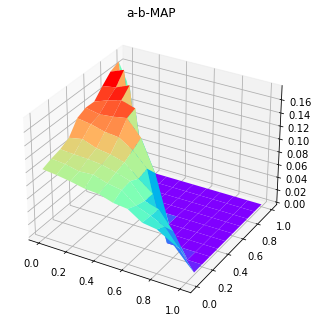

In [86]:
a_range = np.arange(0,1.1,0.1)
b_range = np.arange(0,1.1,0.1)
X,Y = np.meshgrid(a_range, b_range)
Z = []
for a in a_range:
    tmp = []
    for b in b_range:
        c = 1.0-a-b
        if c>=0 and c<=1:
            index = "6-%f-%f-%f" %(a, b, 1.0-a-b)
            tmp.append(summary[index]["MAP"])
        else:
            tmp.append(0)
    Z.append(tmp)
Z = np.array(Z)

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='rainbow')
plt.title("a-b-MAP")

Text(0.5, 0.92, 'a-b-MAP')

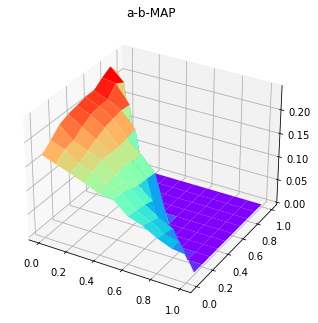

In [89]:
a_range = np.arange(0,1.1,0.1)
b_range = np.arange(0,1.1,0.1)
X,Y = np.meshgrid(a_range, b_range)
Z = []
for a in a_range:
    tmp = []
    for b in b_range:
        c = 1.0-a-b
        if c>=0 and c<=1:
            index = "5-%f-%f-%f" %(a, b, 1.0-a-b)
            tmp.append(summary[index]["MAP"])
        else:
            tmp.append(0)
    Z.append(tmp)
Z = np.array(Z)

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='rainbow')
plt.title("a-b-MAP")

In [19]:
# for k, v in summary.items():
#     print(k, v)
print(summary["7-0.800000-0.000000-0.200000"])

{'MAP': 0.2054, 'P@10': 0.77, 'P@20': 0.66, 'P@30': 0.56}


In [13]:
sorted(summary.items(), key=lambda x:x[1]["MAP"], reverse=True)

[('7-0.400000-0.000000-0.100000',
  {'MAP': 0.2054, 'P@10': 0.77, 'P@20': 0.66, 'P@30': 0.56}),
 ('7-0.800000-0.000000-0.200000',
  {'MAP': 0.2054, 'P@10': 0.77, 'P@20': 0.66, 'P@30': 0.56}),
 ('7-1.000000-0.000000-0.300000',
  {'MAP': 0.2054, 'P@10': 0.77, 'P@20': 0.655, 'P@30': 0.5667}),
 ('7-0.500000-0.000000-0.100000',
  {'MAP': 0.2052, 'P@10': 0.78, 'P@20': 0.665, 'P@30': 0.56}),
 ('7-0.700000-0.000000-0.200000',
  {'MAP': 0.2052, 'P@10': 0.76, 'P@20': 0.66, 'P@30': 0.5667}),
 ('7-1.000000-0.000000-0.200000',
  {'MAP': 0.2052, 'P@10': 0.78, 'P@20': 0.665, 'P@30': 0.56}),
 ('7-0.600000-0.000000-0.100000',
  {'MAP': 0.2049, 'P@10': 0.77, 'P@20': 0.67, 'P@30': 0.5667}),
 ('7-0.900000-0.000000-0.200000',
  {'MAP': 0.2048, 'P@10': 0.77, 'P@20': 0.66, 'P@30': 0.5567}),
 ('7-0.700000-0.000000-0.100000',
  {'MAP': 0.2042, 'P@10': 0.76, 'P@20': 0.685, 'P@30': 0.5633}),
 ('7-1.000000-0.100000-0.200000',
  {'MAP': 0.2041, 'P@10': 0.74, 'P@20': 0.65, 'P@30': 0.5667}),
 ('7-0.300000-0.000000-0

# EXP4

In [7]:
param_text = """indexPath=INPUT_DIR/index-gov2
queryFilePath=TEST_DIR/HW2-Exp-%s.qry
trecEvalOutputPath=OUTPUT_DIR/HW2-Exp-%s.teIn
trecEvalOutputLength=100
retrievalAlgorithm=Indri
Indri:mu=1500
Indri:lambda=0.01"""

qry_text = """711:Train station security measures
730: Gastric bypass complications
733:Airline overbooking
751: Scrabble Players
758 : Embryonic stem cells
764 :Increase mass transit use
802:Volcano eruptions global temperature
809:wetlands  wastewater  treatment
811:handwriting recognition
826:Florida Seminole Indians"""

In [8]:
def get_text(weight):
    field = ['url', 'keywords', 'title', 'body']
    output = ""
    for line in qry_text.split('\n'):
        token = line.split(":")
        words = token[1].strip().split()
        tmp = "%s: #AND(" % token[0]
        fmt = "#WSUM(%f %s.%s %f %s.%s %f %s.%s %f %s.%s)"
        for word in words:
            tmp += fmt % (weight[0],word,field[0],weight[1],word,field[1],weight[2],word,field[2],weight[3],word,field[3]) + " "
        tmp += ")"
        output+= tmp + "\n"
    return output

In [9]:
indexes = []
for a in np.arange(0,1.1,0.1):
    for b in np.arange(0,1.1,0.1):
        for c in np.arange(0,1.1,0.1):
            d = 1.0-a-b-c
            if d>=0 and d<=1.0:
                index = "4-%f-%f-%f-%f" %(a,b,c,d)
                indexes.append(index)
                with open("PARAM_DIR/HW2-Exp-%s.param"%index, 'w+') as f:
                    f.write(param_text%(index, index))
                with open("TEST_DIR/HW2-Exp-%s.qry"%index, 'w+') as f:
                    f.write(get_text([a,b,c,d]))

In [48]:
config = [(0.0,0.1,0.1,0.7),(0.1,0.0,0.1,0.7),(0.1,0.1,0.0,0.7)]
indexes = ["4-%f-%f-%f-%f" % num for num in config]
for index in indexes:
    tokens = index.split('-')
    a,b,c,d = float(tokens[1]),float(tokens[2]),float(tokens[3]),float(tokens[4])
    print(index,a,b,c,d)
    with open("PARAM_DIR/HW2-Exp-%s.param"%index, 'w+') as f:
        f.write(param_text%(index, index))
    with open("TEST_DIR/HW2-Exp-%s.qry"%index, 'w+') as f:
        f.write(get_text([a,b,c,d]))

4-0.000000-0.100000-0.100000-0.700000 0.0 0.1 0.1 0.7
4-0.100000-0.000000-0.100000-0.700000 0.1 0.0 0.1 0.7
4-0.100000-0.100000-0.000000-0.700000 0.1 0.1 0.0 0.7


In [49]:
def run(index):
    params_path = "PARAM_DIR/HW2-Exp-%s.param" % index
    os.system(getCMD(params_path))

def run_test(index):
    output_path = 'OUTPUT_DIR/HW2-Exp-%s.teIn' % index
    tmp = test(output_path)
    return tmp

In [51]:
with Pool(8) as p:
    list(tqdm(p.imap_unordered(run, indexes)))

summary = {}
for index in tqdm(indexes):
    summary[index] = run_test(index)

with open('exp4-3.pkl', 'wb') as f:
    pkl.dump(summary, f)

3it [00:27,  9.25s/it]
100%|██████████| 3/3 [00:01<00:00,  1.97it/s]


In [53]:
for k, v in summary.items():
    print(k,v)

4-0.000000-0.100000-0.100000-0.700000 {'MAP': 0.173, 'P@10': 0.68, 'P@20': 0.625, 'P@30': 0.52}
4-0.100000-0.000000-0.100000-0.700000 {'MAP': 0.1715, 'P@10': 0.68, 'P@20': 0.62, 'P@30': 0.5267}
4-0.100000-0.100000-0.000000-0.700000 {'MAP': 0.1808, 'P@10': 0.69, 'P@20': 0.64, 'P@30': 0.53}


In [19]:
summary = {}
# with open('exp4-1.pkl', 'rb') as f:
#     summary.update(pkl.load(f))
with open('exp4-2.pkl', 'rb') as f:
    summary.update(pkl.load(f))

Text(0.5, 0.92, 'mu-lambda-MAP')

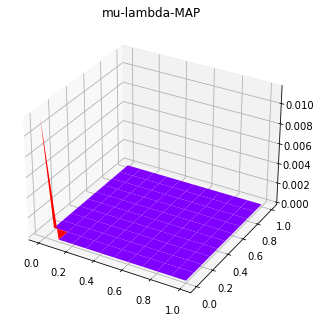

In [20]:
a_range = np.arange(0,1.1,0.1)
b_range = np.arange(0,1.1,0.1)
X,Y = np.meshgrid(a_range, b_range)
Z = []
for a in np.arange(0,1.1,0.1):
    for b in np.arange(0,1.1,0.1):
        tmp = []
        for c in np.arange(0,1.1,0.1):
            d = 1.0-a-b-c
            if d>=0 and d<=1.0:
                index = "4-%f-%f-%f-%f" %(a,b,c,d)
                tmp.append(summary[index]["MAP"])
            else:
                tmp.append(0)
    Z.append(tmp)
Z = np.array(Z)

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='rainbow')
plt.title("mu-lambda-MAP")

In [34]:
tmp = """4.1a #AND(
    #WSUM(%.2f Train.url %.2f Train.keywords %.2f Train.title %.2f Train.body) 
    #WSUM(%.2f station.url %.2f station.keywords %.2f station.title %.2f station.body) 
    #WSUM(%.2f security.url %.2f security.keywords %.2f security.title %.2f security.body) 
    #WSUM(%.2f measures.url %.2f measures.keywords %.2f measures.title %.2f measures.body) )
""" 

In [35]:
config = [0.0, 0.11, 0.11, 0.87]
config = [0., 0.11, 0.11, 0.87]
num = []
for _ in range(4):
    for x in config:
        num.append(x)
print(tmp % tuple(num))

4.1a #AND(
    #WSUM(0.00 Train.url 0.11 Train.keywords 0.11 Train.title 0.87 Train.body) 
    #WSUM(0.00 station.url 0.11 station.keywords 0.11 station.title 0.87 station.body) 
    #WSUM(0.00 security.url 0.11 security.keywords 0.11 security.title 0.87 security.body) 
    #WSUM(0.00 measures.url 0.11 measures.keywords 0.11 measures.title 0.87 measures.body) )



In [22]:
summary['4-0.100000-0.100000-0.000000-0.800000']

{'MAP': 0.1804, 'P@10': 0.69, 'P@20': 0.64, 'P@30': 0.53}

In [23]:
sorted(summary.items(), key=lambda x:x[1]["MAP"], reverse=True)

[('4-0.200000-0.100000-0.000000-0.700000',
  {'MAP': 0.1807, 'P@10': 0.69, 'P@20': 0.64, 'P@30': 0.5267}),
 ('4-0.000000-0.000000-0.000000-1.000000',
  {'MAP': 0.1806, 'P@10': 0.7, 'P@20': 0.63, 'P@30': 0.53}),
 ('4-0.100000-0.000000-0.000000-0.900000',
  {'MAP': 0.1806, 'P@10': 0.7, 'P@20': 0.63, 'P@30': 0.53}),
 ('4-0.000000-0.100000-0.000000-0.900000',
  {'MAP': 0.1805, 'P@10': 0.69, 'P@20': 0.635, 'P@30': 0.53}),
 ('4-0.100000-0.100000-0.000000-0.800000',
  {'MAP': 0.1804, 'P@10': 0.69, 'P@20': 0.64, 'P@30': 0.53}),
 ('4-0.200000-0.000000-0.000000-0.800000',
  {'MAP': 0.1798, 'P@10': 0.7, 'P@20': 0.63, 'P@30': 0.53}),
 ('4-0.300000-0.100000-0.000000-0.600000',
  {'MAP': 0.1798, 'P@10': 0.69, 'P@20': 0.645, 'P@30': 0.52}),
 ('4-0.400000-0.100000-0.000000-0.500000',
  {'MAP': 0.1795, 'P@10': 0.69, 'P@20': 0.645, 'P@30': 0.52}),
 ('4-0.300000-0.000000-0.000000-0.700000',
  {'MAP': 0.1792, 'P@10': 0.7, 'P@20': 0.635, 'P@30': 0.53}),
 ('4-0.400000-0.000000-0.000000-0.600000',
  {'MAP': 

# EXP3

In [4]:
def run(index):
    params_path = "PARAM_DIR/HW2-Exp-%s.param" % index
    os.system(getCMD(params_path))

In [5]:
def run_test(index):
    output_path = 'OUTPUT_DIR/HW2-Exp-%s.teIn' % index
    tmp = test(output_path)
    return tmp

In [6]:
param_text = """indexPath=INPUT_DIR/index-gov2
queryFilePath=TEST_DIR/HW2-Exp-%s.qry
trecEvalOutputPath=OUTPUT_DIR/HW2-Exp-%s.teIn
trecEvalOutputLength=100
retrievalAlgorithm=Indri
Indri:mu=%d
Indri:lambda=%f"""

qry_text = """711:Train station security measures
730: Gastric bypass complications
733:Airline overbooking
751: Scrabble Players
758 : Embryonic stem cells
764 :Increase mass transit use
802:Volcano eruptions global temperature
809:wetlands  wastewater  treatment
811:handwriting recognition
826:Florida Seminole Indians"""

In [18]:
lam_range = np.array([0.0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
mu_range = np.array([1500, 2500])
indexes = []
for mu in mu_range:
    for lam in lam_range:
        index = "3-%f-%d" %(lam, mu)
        indexes.append(index)
        with open("PARAM_DIR/HW2-Exp-%s.param"%index, 'w+') as f:
            f.write(param_text%(index, index, mu, lam))
        with open("TEST_DIR/HW2-Exp-%s.qry"%index, 'w+') as f:
            f.write(qry_text)

with Pool(8) as p:
    list(tqdm(p.imap_unordered(run, indexes)))

summary = {}
for index in tqdm(indexes):
    summary[index] = run_test(index)

with open('exp3-5.pkl', 'wb') as f:
    pkl.dump(summary, f)

40it [04:29,  6.74s/it]
100%|██████████| 40/40 [00:38<00:00,  1.03it/s]


In [9]:
summary = {}
with open('exp3-1.pkl', 'rb') as f:
    summary.update(pkl.load(f))
with open('exp3-2.pkl', 'rb') as f:
    summary.update(pkl.load(f))
with open('exp3-3.pkl', 'rb') as f:
    summary.update(pkl.load(f))
with open('exp3-4.pkl', 'rb') as f:
    summary.update(pkl.load(f))
with open('exp3-5.pkl', 'rb') as f:
    summary.update(pkl.load(f))
    
lam_range = set()
mu_range = set()
for k in summary.keys():
    tmp = k.split('-')
    lam_range.add(float(tmp[1]))
    mu_range.add(float(tmp[2]))
    
lam_range = np.array(sorted(list(lam_range)))

mu_range = np.array(sorted(list(mu_range)))
# mu_range = mu_range[:17]
mu_range = mu_range[17:]

In [10]:
print(",".join([str(x) for x in lam_range]))
print(",".join([str(int(x)) for x in mu_range]))

0.0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
9000,10000,15000,20000,30000,40000


Text(0.5, 0.92, 'mu-lambda-MAP')

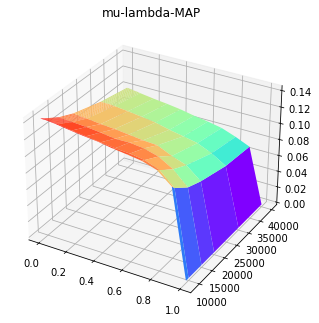

In [11]:
X,Y = np.meshgrid(lam_range, mu_range)
Z = []
for mu in mu_range:
    tmp = []
    for lam in lam_range:
        index = index = "3-%f-%d" %(lam, mu)
        tmp.append(summary[index]["MAP"])
    Z.append(tmp)
Z = np.array(Z)

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='rainbow')
plt.title("mu-lambda-MAP")

Text(0.5, 0.92, 'mu-lambda-MAP')

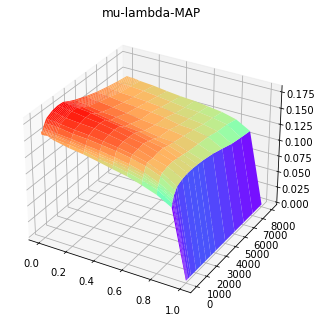

In [6]:
X,Y = np.meshgrid(lam_range, mu_range)
Z = []
for mu in mu_range:
    tmp = []
    for lam in lam_range:
        index = index = "3-%f-%d" %(lam, mu)
        tmp.append(summary[index]["MAP"])
    Z.append(tmp)
Z = np.array(Z)

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='rainbow')
plt.title("mu-lambda-MAP")

In [12]:
for k, v in summary.items():
    if "1500" in k:
        print(k, v)

3-0.000000-15000 {'MAP': 0.1285, 'P@10': 0.55, 'P@20': 0.47, 'P@30': 0.4133}
3-0.100000-15000 {'MAP': 0.1276, 'P@10': 0.55, 'P@20': 0.46, 'P@30': 0.4067}
3-0.200000-15000 {'MAP': 0.1264, 'P@10': 0.54, 'P@20': 0.46, 'P@30': 0.3967}
3-0.300000-15000 {'MAP': 0.1246, 'P@10': 0.5, 'P@20': 0.44, 'P@30': 0.3933}
3-0.400000-15000 {'MAP': 0.1221, 'P@10': 0.5, 'P@20': 0.44, 'P@30': 0.3967}
3-0.500000-15000 {'MAP': 0.1224, 'P@10': 0.49, 'P@20': 0.425, 'P@30': 0.39}
3-0.600000-15000 {'MAP': 0.1204, 'P@10': 0.49, 'P@20': 0.42, 'P@30': 0.3867}
3-0.700000-15000 {'MAP': 0.1157, 'P@10': 0.5, 'P@20': 0.41, 'P@30': 0.3733}
3-0.800000-15000 {'MAP': 0.1056, 'P@10': 0.44, 'P@20': 0.395, 'P@30': 0.3567}
3-0.900000-15000 {'MAP': 0.0893, 'P@10': 0.38, 'P@20': 0.38, 'P@30': 0.3333}
3-1.000000-15000 {'MAP': 0.0, 'P@10': 0.0, 'P@20': 0.0, 'P@30': 0.0033}
3-0.010000-15000 {'MAP': 0.1283, 'P@10': 0.55, 'P@20': 0.47, 'P@30': 0.4133}
3-0.020000-15000 {'MAP': 0.1283, 'P@10': 0.55, 'P@20': 0.47, 'P@30': 0.41}
3-0.03000

In [7]:
sorted(summary.items(), key=lambda x:x[1]["MAP"], reverse=True)

[('3-0.000000-1500', {'MAP': 0.1809, 'P@10': 0.7, 'P@20': 0.63, 'P@30': 0.53}),
 ('3-0.010000-1500', {'MAP': 0.1806, 'P@10': 0.7, 'P@20': 0.63, 'P@30': 0.53}),
 ('3-0.030000-1500', {'MAP': 0.1804, 'P@10': 0.7, 'P@20': 0.63, 'P@30': 0.53}),
 ('3-0.020000-1500', {'MAP': 0.1803, 'P@10': 0.7, 'P@20': 0.63, 'P@30': 0.53}),
 ('3-0.000000-2000',
  {'MAP': 0.1801, 'P@10': 0.69, 'P@20': 0.63, 'P@30': 0.5167}),
 ('3-0.010000-2000',
  {'MAP': 0.18, 'P@10': 0.69, 'P@20': 0.63, 'P@30': 0.5167}),
 ('3-0.020000-2000',
  {'MAP': 0.1797, 'P@10': 0.69, 'P@20': 0.63, 'P@30': 0.5167}),
 ('3-0.040000-1500', {'MAP': 0.1797, 'P@10': 0.7, 'P@20': 0.63, 'P@30': 0.53}),
 ('3-0.030000-2000',
  {'MAP': 0.1796, 'P@10': 0.69, 'P@20': 0.63, 'P@30': 0.5167}),
 ('3-0.050000-1500',
  {'MAP': 0.1792, 'P@10': 0.69, 'P@20': 0.63, 'P@30': 0.53}),
 ('3-0.000000-1000',
  {'MAP': 0.1791, 'P@10': 0.71, 'P@20': 0.63, 'P@30': 0.5367}),
 ('3-0.060000-1500',
  {'MAP': 0.1791, 'P@10': 0.69, 'P@20': 0.625, 'P@30': 0.53}),
 ('3-0.010